In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 22 11:43:45 2022

@author: amygardiner

Random forest regression with all the combined feature data
"""
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import tree
import matplotlib.pyplot as plt

dataset=pd.read_csv('allcombined.csv')
x = dataset.drop(['Price'], axis=1)
x = x.dropna(axis=1)

y = dataset['Price']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.1382021414706582
Mean Squared Error: 8.336645738696047
Root Mean Squared Error: 2.887325014385469


In [63]:
# mean_error=0.09107903016842504 std=4.543720693427225
def findStdOfModel(y_test, y_pred):
  y_errors = np.absolute(y_test - y_pred)
  y_error_mean = np.mean(y_test - y_pred)
  y_error_std = np.std(y_errors)

  return y_error_mean, y_error_std
print(findStdOfModel(y_test, y_pred))

#should be considered as constants
#MEAN_ERROR = 0.09107903016842504
#STD_ERROR = 4.543720693427225

MEAN_ERROR = 0.054396945989190607
STD_ERROR = 2.653514956403557

(0.054396945989190607, 2.653514956403557)


In [96]:
# the random forest is able to predict the cost
# if it predicts higher than the actual cost then perhaps its worth more than it is currently
def transactionDecision(y_pred, y_actual, mean_error, std_error, transaction_threshold):
        if y_pred < (y_actual + mean_error - (std_error * transaction_threshold)):
            return "buy"
        if y_pred > (y_actual + mean_error + (std_error * transaction_threshold)):
            return "sell"
        return "no_transaction"

transactions = list(map(lambda predTuple: transactionDecision(predTuple[0], predTuple[1], MEAN_ERROR, STD_ERROR, 4), np.column_stack((y_pred, y_test))))

In [97]:
def countList(transaction, func):
  i =0
  for t in transaction:
    if func(t):
      i+=1
  return i

numOfBuys = countList(transactions, lambda t: t =='buy')
numOfSells = countList(transactions, lambda t: t =='sell')
numOfNoTransaction = countList(transactions, lambda t: t =='no_transaction')
totalTransactions = countList(transactions, lambda x: x==x)

print(numOfBuys/totalTransactions, numOfSells/totalTransactions, numOfNoTransaction/totalTransactions, totalTransactions)

0.010978493716186005 0.007793042644463079 0.9812284636393509 556907


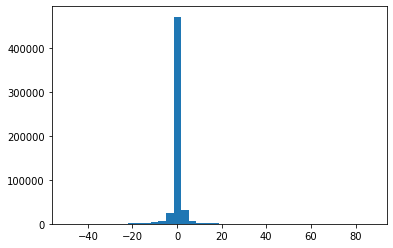

In [98]:
# I want to confirm my assumption that the errors are normally distributed
fig, ax = plt.subplots()
ax.hist(y_test - y_pred, bins=40)
plt.show()

In [100]:
#np.argwhere(transactions)
def getIndexIfBuy(t,i):
  if t=='buy':
     return i

def getIndexIfSell(t,i):
  if t=='sell':
     return i

def applyToList(f):
  indicies = []
  for i in range (len(transactions)):
    temp = f(transactions[i], i)
    if temp:
      indicies.append(temp)
  return indicies

#buyIndicies = list(filter(lambda a: a,map(getIndexIfBuy, transactions, range(len(transactions)))))
#sellIndicies = list(filter(lambda a: a,map(getIndexIfSell, transactions, range(len(transactions)))))
buyIndicies = applyToList(getIndexIfBuy)
sellIndicies = applyToList(getIndexIfSell)

larger=0
smaller=0
for i in buyIndicies:
  if i+1 < len(y_test) and  y_test.values[i] < y_test.values[i+1]:
      larger+=1
  else:
      smaller+=1

print("good buys",larger/(larger + smaller), "of total buys", len(buyIndicies))

larger=0
smaller=0
for i in sellIndicies:
  if i+1 < len(y_test) and y_test.values[i] < y_test.values[i+1]:
      larger+=1
  else:
      smaller+=1

print("good sells",smaller/(larger + smaller), "of total sells", len(sellIndicies))

good buys 0.6601243048740595 of total buys 6114
good sells 0.5518433179723502 of total sells 4340


Results:

0 std:
good buys 0.6204450966006358 of total buys 4089, 
good sells 0.6011018463371054 of total sells 6716

0.5 std:
good buys 0.7414500683994528 of total buys 1462, 
good sells 0.6283343212803794 of total sells 1687

1 std:
good buys 0.8040540540540541 of total buys 888, 
good sells 0.6391129032258065 of total sells 992

2 std:
good buys 0.8167420814479638 of total buys 442, 
good sells 0.6379310344827587 of total sells 464

3 std:
good buys 0.8467432950191571 of total buys 261, 
good sells 0.688212927756654 of total sells 263

6 std:
good buys 1.0 of total buys 7, 
good sells 0.75 of total sells 8

Suprisingly this simple way of choosing buying and selling transaction can have great performace. But this should be more vigorously tested using a trading simulator

The greater the standard deviation threshold the greater the performace, however the greater the threshold the less transactions are done. I think the best way to go about this would be use a high threshold but buy larger amounts, as we can have higher confidence that it will increase in value.

I also noticed that performace increased slowly for sell transactions, compared to buy transactions. I had my suspitions about this when visualising the data as there were mor buy 'signals'. For this reason I suggest we either don't consider sell transactions or we increase the threshold to something exetremly high like 6 standard deviations.

In [101]:
transactionsDf = pd.DataFrame({'transactionType': transactions, 'priceAtTimeOfTransaction': y_test, 'amountOfUnitsTransacted':1})

In [102]:
transactionsDf.to_csv("TransactionDecisions.csv")

In [103]:
transactionsDf[transactionsDf["transactionType"] != 'no_transaction'].to_csv("FilteredTransactionDecisions.csv")